In [4]:
# %pip install langchain
# # %pip install langchain-openai
# # %pip install langchainhub
# # %pip install pypdf
# %pip install chromadb
# %pip install pandas

In [ ]:
# Add the necessary imports at the beginning
# %pip install langgraph

# DISCLAIMER: 

```
FOR THIS NOTEBOOK YOU WILL NEED TO BE RUNNING LOCALLY OLLAMA
```

See [here](https://python.langchain.com/v0.2/docs/integrations/chat/ollama/) for how to set that up.

In [1]:
import os
import getpass

# Set OPENAI API Key

import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

A vector database is a way to store these embeddings, these numerical representations that we just discussed.

The pipeline is:
- In coming document
- Create chunks of text from that document
- Embed each chunk
- Store these embeddings

![](2023-07-30-19-32-13.png)

[LangChain for LLM Application Development by Deeplearning.ai](https://learn.deeplearning.ai/langchain/lesson/1/introduction)

In [2]:
import pandas as pd

file_path="./assets-resources/superheroes.csv"
df = pd.read_csv(file_path)

df.head()

,Superhero Name,Superpower,Power Level,Catchphrase
0,Captain Thunder,Bolt Manipulation,90,Feel the power of the storm!
1,Silver Falcon,Flight and Agility,85,"Soar high, fearlessly!"
2,Mystic Shadow,Invisibility and Illusions,78,Disappear into the darkness!
3,Blaze Runner,Pyrokinesis,88,Burn bright and fierce!
4,Electra-Wave,Electric Manipulation,82,Unleash the electric waves!


In [3]:
from langchain.document_loaders.csv_loader import CSVLoader

In [4]:
loader = CSVLoader(file_path)
data = loader.load()
data[:5]

[Document(metadata={'source': './assets-resources/superheroes.csv', 'row': 0}, page_content='Superhero Name: Captain Thunder\nSuperpower: Bolt Manipulation\nPower Level: 90\nCatchphrase: Feel the power of the storm!'),
 Document(metadata={'source': './assets-resources/superheroes.csv', 'row': 1}, page_content='Superhero Name: Silver Falcon\nSuperpower: Flight and Agility\nPower Level: 85\nCatchphrase: Soar high, fearlessly!'),
 Document(metadata={'source': './assets-resources/superheroes.csv', 'row': 2}, page_content='Superhero Name: Mystic Shadow\nSuperpower: Invisibility and Illusions\nPower Level: 78\nCatchphrase: Disappear into the darkness!'),
 Document(metadata={'source': './assets-resources/superheroes.csv', 'row': 3}, page_content='Superhero Name: Blaze Runner\nSuperpower: Pyrokinesis\nPower Level: 88\nCatchphrase: Burn bright and fierce!'),
 Document(metadata={'source': './assets-resources/superheroes.csv', 'row': 4}, page_content='Superhero Name: Electra-Wave\nSuperpower: Ele

In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="gemma3",
    verbose=True,
)

In [6]:
llm.invoke("What do you know about superheros?")

AIMessage(content='Okay, let\'s dive into the world of superheroes! I have a *lot* of information, thanks to the vast amounts of data I\'ve been trained on. Here\'s a breakdown of what I know, categorized for clarity:\n\n**1. Core Concepts & History:**\n\n* **What are Superheroes?** At their core, superheroes are fictional characters with extraordinary abilities, often possessing powers beyond human capabilities. They typically operate outside the law, striving to protect the innocent and fight against evil.\n* **Origins:** The concept of superheroes really took off in the **Golden Age of Comics (1930s-1950s)**.  This era saw the creation of the foundational heroes:\n    * **Superman (1938):** Often considered *the* first superhero. Created by Jerry Siegel and Joe Shuster, he set the standard for the genre with his invulnerability, flight, and "truth, justice, and the American way."\n    * **Batman (1939):** Created by Bob Kane and Bill Finger, a darker, detective-oriented hero offerin

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
all_splits = text_splitter.split_documents(data)

In [ ]:
# Embed and store
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings

vectordb = Chroma.from_documents(documents=all_splits, embedding=OllamaEmbeddings(model='nomic-embed-text'))

In [9]:
question = "What is the name of the thunder super hero?"
docs = vectordb.similarity_search(question)
len(docs)

4

In [10]:
docs

[Document(metadata={'row': 0, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Captain Thunder\nSuperpower: Bolt Manipulation\nPower Level: 90\nCatchphrase: Feel the power of the storm!'),
 Document(metadata={'row': 30, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Thunderstrike\nSuperpower: Lightning Control\nPower Level: 91\nCatchphrase: Electrify the battlefield!'),
 Document(metadata={'row': 20, 'source': './assets-resources/superheroes.csv'}, page_content="Superhero Name: Stormbringer\nSuperpower: Weather Manipulation\nPower Level: 93\nCatchphrase: Unleash the storm's fury!"),
 Document(metadata={'row': 8, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Steel Titan\nSuperpower: Super Strength and Durability\nPower Level: 95\nCatchphrase: Indestructible force of nature!')]

In [ ]:
for doc in docs:
    print(doc.page_content)
    print("-"*100)

Superhero Name: Captain Thunder
Superpower: Bolt Manipulation
Power Level: 90
Catchphrase: Feel the power of the storm!
----------------------------------------------------------------------------------------------------
Superhero Name: Thunderstrike
Superpower: Lightning Control
Power Level: 91
Catchphrase: Electrify the battlefield!
----------------------------------------------------------------------------------------------------
Superhero Name: Stormbringer
Superpower: Weather Manipulation
Power Level: 93
Catchphrase: Unleash the storm's fury!
----------------------------------------------------------------------------------------------------
Superhero Name: Steel Titan
Superpower: Super Strength and Durability
Power Level: 95
Catchphrase: Indestructible force of nature!
----------------------------------------------------------------------------------------------------


In [12]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),
    ('human', '{input}')
])


rag_chain_from_docs = (
    {
        'input': lambda x: x['input'],
        'context': lambda x: format_docs(x['context']), 
    }
    | prompt
    | llm
    | StrOutputParser()
)

retriever = vectordb.as_retriever()

# passing the input query to the retriever
retrieve_docs = (lambda x: x['input']) | retriever

qa_chain = RunnablePassthrough.assign(context=retrieve_docs).assign(
    answer=rag_chain_from_docs
)

In [13]:
question = "What is the catch phrase for the super hero with the power of producing balls of fire?"
result = qa_chain.invoke({'input': question})
result

{'input': 'What is the catch phrase for the super hero with the power of producing balls of fire?',
 'context': [Document(metadata={'row': 24, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Blazing Comet\nSuperpower: Fireball Projection\nPower Level: 82\nCatchphrase: Burn brighter than a comet!'),
  Document(metadata={'row': 42, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Solar Flare\nSuperpower: Solar Energy Projection\nPower Level: 85\nCatchphrase: Feel the burning light!'),
  Document(metadata={'row': 3, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Blaze Runner\nSuperpower: Pyrokinesis\nPower Level: 88\nCatchphrase: Burn bright and fierce!'),
  Document(metadata={'row': 11, 'source': './assets-resources/superheroes.csv'}, page_content='Superhero Name: Starburst\nSuperpower: Energy Projection\nPower Level: 83\nCatchphrase: Ignite the cosmos!')],
 'answer': 'Blazing Comet’s catchphrase

In [14]:
df.iloc[24]

Superhero Name                  Blazing Comet
Superpower                Fireball Projection
Power Level                                82
Catchphrase       Burn brighter than a comet!
Name: 24, dtype: object

In [15]:
# from langchain.chains.combine_documents import create_stuff_documents_chain
# from langchain.chains import create_retrieval_chain
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.runnables import RunnablePassthrough
# from langchain_core.output_parsers import StrOutputParser

# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


# system_prompt = (
#     "You are an assistant for question-answering tasks. "
#     "Use the following pieces of retrieved context to answer "
#     "the question. If you don't know the answer, say that you "
#     "don't know. Use three sentences maximum and keep the "
#     "answer concise."
#     "\n\n"
#     "{context}"
# )

# prompt = ChatPromptTemplate.from_messages([
#     ('system', system_prompt),
#     ('human', '{input}')
# ])


# rag_chain_from_docs = (
#     {
#         'input': lambda x: x['input'],
#         'context': lambda x: format_docs(x['context']), 
#     }
#     | prompt
#     | llm
#     | StrOutputParser()
# )

# retriever = vectordb.as_retriever()

# # passing the input query to the retriever
# retrieve_docs = (lambda x: x['input']) | retriever

# qa_chain = RunnablePassthrough.assign(context=retrieve_docs).assign(
#     answer=rag_chain_from_docs

# LangGraph Implementation
# Let's implement the same RAG pipeline using LangGraph for better workflow management

from langgraph.graph import START, StateGraph, END
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class CSVRAGState(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve_csv(state: CSVRAGState):
    """Retrieve relevant superhero documents based on the question"""
    retrieved_docs = vectordb.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate_csv_answer(state: CSVRAGState):
    """Generate answer using the retrieved superhero context"""
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = [
        ("system", system_prompt.format(context=docs_content)),
        ("human", state["question"])
    ]
    response = llm.invoke(messages)
    return {"answer": response.content}

# Build the LangGraph workflow
csv_graph_builder = StateGraph(CSVRAGState).add_sequence([retrieve_csv, generate_csv_answer])
csv_graph_builder.add_edge(START, "retrieve_csv")
csv_graph_builder.add_edge("generate_csv_answer", END)
csv_rag_graph = csv_graph_builder.compile()

print("LangGraph CSV RAG pipeline created successfully!")

LangGraph CSV RAG pipeline created successfully!


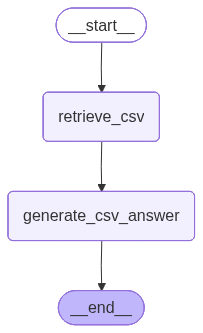

In [16]:
from IPython.display import Image, display

display(Image(csv_rag_graph.get_graph().draw_mermaid_png()))

In [17]:
# Test the LangGraph pipeline with the same questions

# Question 1: Thunder superhero
question1 = "What is the name of the thunder super hero?"
result1 = csv_rag_graph.invoke({"question": question1})

print("=== LangGraph Results ===")
print(f"Question: {question1}")
print(f"Answer: {result1['answer']}")
print("\nRetrieved Context:")
for i, doc in enumerate(result1['context'], 1):
    print(f"{i}. {doc.page_content}")

print("\n" + "="*50 + "\n")

# Question 2: Fire superhero
question2 = "What is the catch phrase for the super hero with the power of producing balls of fire?"
result2 = csv_rag_graph.invoke({"question": question2})

print(f"Question: {question2}")
print(f"Answer: {result2['answer']}")
print("\nRetrieved Context:")
for i, doc in enumerate(result2['context'], 1):
    print(f"{i}. {doc.page_content}")

=== LangGraph Results ===
Question: What is the name of the thunder super hero?
Answer: Based on the provided information, there are three superheroes named Thunder. Captain Thunder, Thunderstrike, and Stormbringer all have “Thunder” in their names and possess powers related to storms and lightning. I do not have enough information to determine which one you are referring to.

Retrieved Context:
1. Superhero Name: Captain Thunder
Superpower: Bolt Manipulation
Power Level: 90
Catchphrase: Feel the power of the storm!
2. Superhero Name: Thunderstrike
Superpower: Lightning Control
Power Level: 91
Catchphrase: Electrify the battlefield!
3. Superhero Name: Stormbringer
Superpower: Weather Manipulation
Power Level: 93
Catchphrase: Unleash the storm's fury!
4. Superhero Name: Steel Titan
Superpower: Super Strength and Durability
Power Level: 95
Catchphrase: Indestructible force of nature!


Question: What is the catch phrase for the super hero with the power of producing balls of fire?
Answer

In [ ]:
# Visualize the LangGraph workflow (optional)
# Uncomment the lines below if you want to see the graph visualization

# from IPython.display import Image, display
# try:
#     display(Image(csv_rag_graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"Graph visualization not available: {e}")
#     print("The LangGraph workflow: START -> retrieve_csv -> generate_csv_answer -> END")

# Stream the workflow to see step-by-step execution
print("=== Streaming LangGraph Execution ===")
for step in csv_rag_graph.stream(
    {"question": "Who has the highest power level?"}, stream_mode="updates"
):
    print(f"{step}\n")
    print("-" * 40)